# REST-API example impactu

In [1]:
import pandas as pd
import requests
import json
from IPython.display import JSON
from unidecode import unidecode
def flatten(xss):
    return [x for xs in xss for x in xs]

Obtain "Uiversidad de Antioquia" works

In [2]:
import pandas as pd
import requests
#%%time
DJ = []
total = 105018 
#total = 965
page_ini = 1
max_page = 250
extra_page = 0
if total%max_page != 0:
    extra_page = 1
page_end = total//max_page + extra_page
for p in range(page_ini,page_end+1):
    url = f'https://api.impactu.colav.co/affiliation/institution/03bp5hc83/research/products?max={max_page}&page={p}'
    #url = f'https://api.impactu.colav.co/search/works?max={max_page}&page={p}&status=diamond&subjects=1_Library+science'
    dj = requests.get(url)
    if dj.status_code == 200:
        print(p,end="\r")
        jl = dj.json()['data']
        for d in jl:
            kk = d.pop('abstracts')
        i = 0
        for d in jl:
            if len(jl[i]['authors']) > 10:
                kk = jl.pop(i)
            else:
                i += 1        

        
        DJ = DJ +  jl

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

In [3]:
len(DJ)

102165

save the list to a JSON file

In [4]:
f = open('udea.json','w')
json.dump(DJ,f)
f.close()

In [6]:
ls -lh udea.json

-rw-r--r-- 1 restrepo restrepo 860M Feb 13 13:30 udea.json


In [2]:
f = open('udea.json','r')
DJ = json.load(f)
f.close()

## Analysis in pandas

### Authors

In [74]:
df = pd.DataFrame(DJ)

In [75]:
df.shape

(102165, 23)

search authors

In [6]:
full_name = 'diego alejandro restrepo quintero'
#full_name = 'carlos alberto duque echeverri'
dfa = df[df.authors.apply(lambda L: any([True for d in L if unidecode(str(d.get('full_name')).lower()) == full_name ]))]

Check the json:

In [7]:
#JSON(dfa.authors.iloc[0])

De conformidad  con lo dispuesto en el Acuerdo Superior 083 del 22 de julio de 1996 (Estatuto profesoral) la carrera docente de la institución se compone  de las categorías de profesor auxiliar, profesor asistente, profesor asociado y profesor titular. 

In [8]:
#JSON(df.authors.iloc[80049])

remove not scienti authors...

In [77]:
df['scienti_authors'] = df.authors.apply(lambda L: [
                          {'COD_RH':d.get('external_ids')[0].get('id'),
                           'last_names':d.get('last_names'),
                           'first_names':d.get('first_names'),
                           'sex':d.get('sex').lower(),
                           'age':d.get('age'),
                           'affiliations': [{'name': dd.get('name'),
                                             'id': dd.get('id'),
                                             'type': dd.get('types')[0].get('type')
                                            } for dd in d.get('affiliations')],
                           'ranking': [dd for dd in d.get('ranking') if dd.get('source') == 'categoría_laboral' ]
                          } for d in L 
                            if d.get('sex') and 
                            any([True for dd in d.get('external_ids') 
                                 if dd.get('provenance') == 'scienti' and dd.get('source') == 'scienti'])   ])

In [78]:
L = df['scienti_authors'].to_list()
L = flatten(L)
dfL = pd.DataFrame(L)
del L
dfL.shape

(125680, 7)

In [79]:
udea = dfL[dfL['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'Education' and d.get('name') == 'Universidad de Antioquia']).apply(len)>0
         ].reset_index(drop=True)

In [80]:
udea['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'Education']).iloc[0]

['Universidad de Antioquia', 'Universidad de Pamplona']

In [81]:
udea.affiliations.iloc[0]

[{'name': 'Universidad de Antioquia', 'id': '03bp5hc83', 'type': 'Education'},
 {'name': 'Instituto de Biología',
  'id': '03bp5hc83_3_21420003_3513',
  'type': 'department'},
 {'name': 'Facultad de Ciencias Exactas y Naturales',
  'id': '03bp5hc83_3',
  'type': 'faculty'},
 {'name': 'Gebiomic (genética y Bioquímica de Microorganismos)',
  'id': 'COL0014064',
  'type': 'group'},
 {'name': 'Corporación para Investigaciones Biológicas',
  'id': '03evkbw14',
  'type': 'Facility'},
 {'name': 'Universidad de Pamplona', 'id': '04dfr7a85', 'type': 'Education'},
 {'name': 'Genética, Regeneración y Cáncer',
  'id': 'COL0006769',
  'type': 'group'}]

In [82]:
ror = '03bp5hc83'
udea['faculty'] = udea['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'faculty' and d.get('id').find(ror) > -1  ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]
udea['department'] = udea['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'department' and d.get('id').find(ror) > -1 ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]

udea['group'] = udea['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'group' ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]

In [83]:
udea.shape

(119360, 10)

In [84]:
udea.drop_duplicates(subset=['COD_RH','sex','age','faculty','department','group']).shape

(4607, 10)

In [85]:
udea.drop_duplicates(subset=['COD_RH']).shape

(4607, 10)

In [86]:
udea = udea.drop_duplicates(subset=['COD_RH']).reset_index(drop=True)

In [87]:
fm = udea['sex'].value_counts()
print(f"{round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

46.0 % of 4605


In [88]:
fm = udea['sex'].value_counts()
print(f"UdeA: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")
for f in udea.faculty.unique() :
    udea_f = udea[udea['faculty'] == f]
    fm = udea_f['sex'].value_counts()
    if not fm.get('mujer'):
        fm['mujer'] = 0
    if not fm.get('hombre'):
        fm['hombre'] = 0        
    print(f"{f}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")
    for ff in  udea_f.department.unique():
        udea_d = udea[ ((udea['faculty'] == f) & (udea['department'] == ff)) ]
        fm = udea_d['sex'].value_counts()
        if not fm.get('mujer'):
            fm['mujer'] = 0
        if not fm.get('hombre'):
            fm['hombre'] = 0        
        print(f"   {ff}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

    #if f == 'Escuela de Microbiología':
    #    break

UdeA: 46.0 % of 4605
Facultad de Ciencias Exactas y Naturales: 25.5 % of 294
   Instituto de Biología: 44.0 % of 75
   Instituto de Química: 26.2 % of 80
   Instituto de Física: 12.7 % of 79
   unknown: 33.3 % of 3
   Departamento de Matemáticas: 16.7 % of 54
   Programa Ingeniería Civil: 0.0 % of 1
   Programa Regionalización Urabá: 50.0 % of 2
Facultad de Medicina: 43.9 % of 481
   Departamento de Cirugía: 23.7 % of 59
   Departamento de Farmacología y Toxicología: 50.0 % of 22
   Departamento de Microbiología y Parasitología: 56.1 % of 57
   Departamento de Pediatría y Puericultura: 54.1 % of 74
   Departamento de Medicina Interna: 29.9 % of 77
   Instituto de Investigaciones Médicas: 46.2 % of 39
   Centro de Investigaciones Médicas: 50.0 % of 8
   Departamento de Fisiología: 40.7 % of 27
   Departamento de Siquiatría y Ciencias del Comportamiento Humano: 29.4 % of 17
   Departamento de Morfología: 33.3 % of 9
   Departamento de Bioquímica: 33.3 % of 3
   Departamento de Obstetrici

In [89]:
for r in [ 'AUXILIAR' , 'ASISTENTE','ASOCIADO','TITULAR']:
    fm = udea[udea['ranking'].apply(lambda L: r in [d.get('rank') for d in L])]['sex'].value_counts()
    print(f"{r}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

AUXILIAR: 46.5 % of 1296
ASISTENTE: 46.7 % of 1984
ASOCIADO: 43.1 % of 1189
TITULAR: 41.3 % of 809


In [90]:
f = 'Facultad de Ciencias Exactas y Naturales'
ff = 'Instituto de Física'
udea_f = udea[ ((udea['faculty'] == f)) ]
udea_d = udea[ ((udea['faculty'] == f) & (udea['department'] == ff)) ]

In [91]:
for r in [ 'AUXILIAR' , 'ASISTENTE','ASOCIADO','TITULAR']:
    fm = udea_f[udea_f['ranking'].apply(lambda L: r in [d.get('rank') for d in L])]['sex'].value_counts()
    print(f"{r}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

AUXILIAR: 26.1 % of 111
ASISTENTE: 26.4 % of 208
ASOCIADO: 21.4 % of 126
TITULAR: 20.0 % of 95


In [92]:
for r in [ 'AUXILIAR' , 'ASISTENTE','ASOCIADO','TITULAR']:
    fm = udea_d[udea_d['ranking'].apply(lambda L: r in [d.get('rank') for d in L])]['sex'].value_counts()
    print(f"{r}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

AUXILIAR: 15.4 % of 26
ASISTENTE: 11.1 % of 54
ASOCIADO: 3.1 % of 32
TITULAR: 3.6 % of 28


In [93]:
import matplotlib.pyplot as plt
import numpy as np

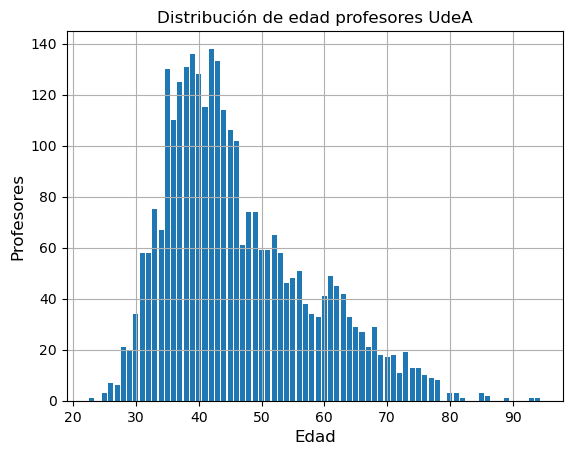

In [94]:
kk = udea['age'].sort_values().dropna().astype(int).value_counts()

age = pd.DataFrame()

age['age'] = kk.keys()

age['counts'] = kk.values

age = age.sort_values('age')

plt.bar(age['age'],age['counts'])
plt.xlabel('Edad', size = 12)
plt.ylabel('Profesores', size = 12)
plt.title('Distribución de edad profesores UdeA')
plt.grid()

In [95]:
f = 'Facultad de Ciencias Exactas y Naturales'
ff = 'Instituto de Física'
udea_f = udea[ ((udea['faculty'] == f)) ]
udea_d = udea[ ((udea['faculty'] == f) & (udea['department'] == ff)) ]

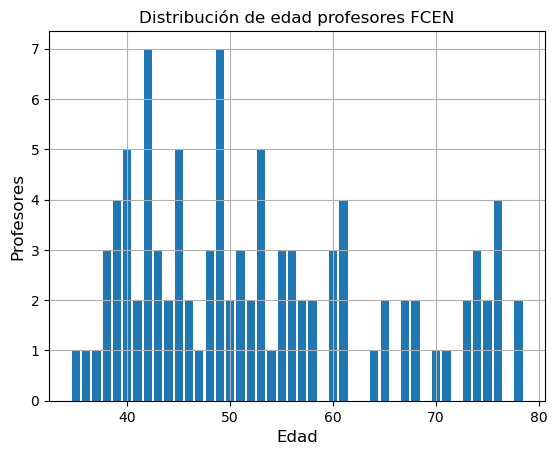

In [96]:
kk = udea_f['age'].sort_values().dropna().astype(int).value_counts()

age = pd.DataFrame()

age['age'] = kk.keys()

age['counts'] = kk.values

age = age.sort_values('age')

plt.bar(age['age'],age['counts'])
plt.xlabel('Edad', size = 12)
plt.ylabel('Profesores', size = 12)
plt.title('Distribución de edad profesores FCEN')
plt.grid()

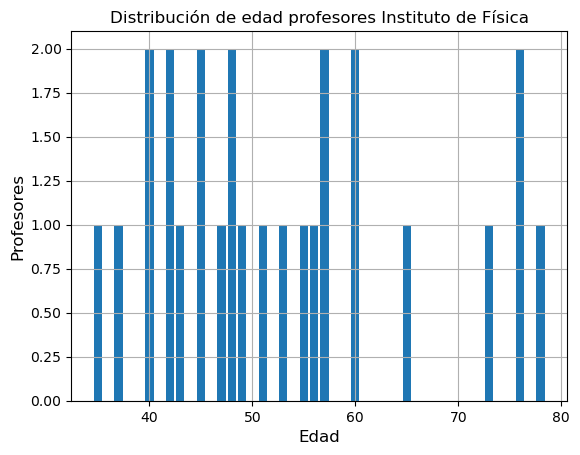

In [97]:
kk = udea_d['age'].sort_values().dropna().astype(int).value_counts()

age = pd.DataFrame()

age['age'] = kk.keys()

age['counts'] = kk.values

age = age.sort_values('age')

plt.bar(age['age'],age['counts'])
plt.xlabel('Edad', size = 12)
plt.ylabel('Profesores', size = 12)
plt.title('Distribución de edad profesores Instituto de Física')
plt.grid()

In [98]:
y = 2020
dfy = df[df.year_published == y]

In [99]:
    L = dfy['scienti_authors'].to_list()
    L = flatten(L)

    dfL = pd.DataFrame(L)

In [100]:
dfL.shape

(7080, 7)

In [101]:
dfL.drop_duplicates('COD_RH').shape

(2342, 7)

In [102]:
df.shape

(102165, 24)

In [103]:
CHECK_OPENALEX = False # Count larger that OpenAlex is expected
if CHECK_OPENALEX:
    df = df[df['types'].apply(lambda L: any([True for d in L 
                                         if d.get('source') == 'openalex' #or
                                             #d.get('type') == 'Artículo'
                                        ]))].reset_index(drop = True)

In [104]:
# df = df[df['types'].apply(lambda L: 'openalex' not in [d.get('source') for d in L])]
# df = df[df['types'].apply(lambda L: 'Artículo' not in [d.get('type') for d in L])].reset_index(drop=True)

In [105]:
df.shape

(102165, 24)

In [106]:
df['openalex'] = df['external_ids'].apply(lambda L: [d.get('id') for d in L if d.get('source') == 'openalex']).str[0]

In [107]:
df.drop_duplicates(subset=['openalex']).shape

(48224, 25)

In [128]:
FACULTY = False
DEPARTMENT = False
UDEA = pd.DataFrame()
w = []
for y in [y for y in set(df.year_published.fillna(0).astype(int)) if y > 0]:
    dfy = df[df.year_published == y]
    if dfy.empty:
        continue
    L = dfy['scienti_authors'].to_list()
    L = flatten(L)
    if not L:
        continue
    dfL = pd.DataFrame(L)
    del L

    # Filter pure UdeA authors
    udeay = dfL[dfL['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'Education' and d.get('name') == 'Universidad de Antioquia']).apply(len)>0
         ].reset_index(drop=True)   

    udeay['faculty'] = udeay['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'faculty' and d.get('id').find(ror) > -1  ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]
    udeay['department'] = udeay['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'department' and d.get('id').find(ror) > -1 ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]
    udeay['group'] = udeay['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'group' ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]    
    udeay = udeay.drop_duplicates(subset=['COD_RH']).reset_index(drop=True)

    udeay['year'] = y
    UDEA = pd.concat((UDEA,udeay)) 
    
    if FACULTY:
        f = 'Facultad de Ciencias Exactas y Naturales'
        udeay = udeay[ ((udeay['faculty'] == f)) ]
    if DEPARTMENT:       
        ff = 'Instituto de Física'
        udeay = udeay[ ((udeay['faculty'] == f) & (udeay['department'] == ff)) ]
    
    #.drop_duplicates(subset=['COD_RH']).reset_index(drop=True)

    d = {}
    d['year'] = y
    d['works'] = dfy.shape[0]
    d['hombre'] = udeay[udeay['sex'] == 'hombre'].shape[0]
    d['mujer'] = udeay[udeay['sex'] == 'mujer'].shape[0]
    d['authors'] = d['hombre'] + d['mujer']
    w.append(d)

Text(0, 0.5, 'works')

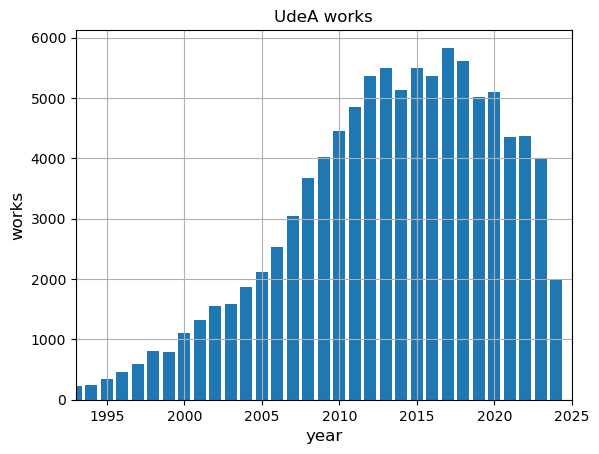

In [129]:
dw = pd.DataFrame(w).sort_values('year')
dw['f/m'] = round(dw['mujer']/dw['authors'],4)

plt.bar(dw['year'],dw['works'])
plt.xlim(1993,2025)
plt.grid()
plt.title('UdeA works')
plt.xlabel('year',size = 12)
plt.ylabel('works',size = 12)

Text(0, 0.5, 'professors')

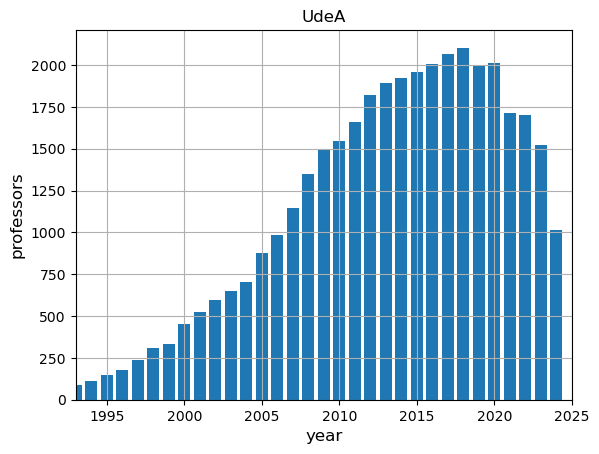

In [130]:
plt.bar(dw['year'],dw['authors'])
plt.xlim(1993,2025)
plt.grid()
plt.title('UdeA')
if FACULTY:
    plt.title(f)
if DEPARTMENT:
    plt.title(ff)

plt.xlabel('year',size = 12)
plt.ylabel('professors',size = 12)

Text(0, 0.5, 'female ratio')

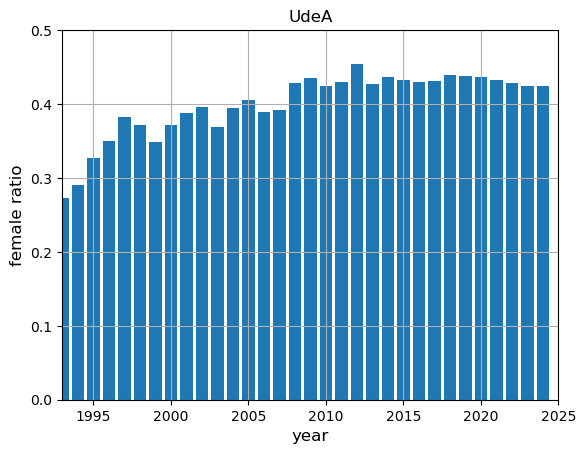

In [131]:
plt.bar(dw['year'],dw['f/m'])
plt.xlim(1993,2025)
plt.grid()
plt.ylim(0,0.5)
if DEPARTMENT:
    plt.xlim(2002,2025)
    plt.ylim(0,0.1)

plt.title('UdeA')
if FACULTY:
    plt.title(f)
if DEPARTMENT:
    plt.title(ff)

plt.xlabel('year',size = 12)
plt.ylabel('female ratio',size = 12)

In [132]:
UDEA['full_name']=UDEA.first_names.apply(' '.join)+' '+UDEA.last_names.apply(' '.join)

In [133]:
y1 = 2020
y2 = 2023
udea_diff = pd.DataFrame({'COD_RH' : list(set(UDEA[UDEA['year']==y1].COD_RH).difference(UDEA[UDEA['year']==y2].COD_RH))})

In [134]:
udea_diff = udea_diff.merge(UDEA.drop_duplicates('COD_RH')[['COD_RH','full_name','faculty','department']],
                on='COD_RH',how='left')

In [135]:
udea_diff.shape

(887, 4)

In [136]:
dw[-5:-3]

,year,works,hombre,mujer,authors,f/m
62,2020,5101,1134,879,2013,0.4367
63,2021,4354,972,739,1711,0.4319


In [137]:
print(f'Authors which publish in {y1} but not in {y2}:')
#print(f'in {f}')
#udea_diff[udea_diff['faculty'] == f].reset_index(drop=True)
print(f'in {ff}')
udea_diff[udea_diff['department'] == ff].reset_index(drop=True)

Authors which publish in 2020 but not in 2023:
in Instituto de Física


,COD_RH,full_name,faculty,department
0,0000348090,Alvaro Herrera Carrillo,Facultad de Ciencias Exactas y Naturales,Instituto de Física
1,0000037192,Daniel Esteban Jaramillo Arango,Facultad de Ciencias Exactas y Naturales,Instituto de Física
2,0000036897,Jorge Enrique Tobon Gomez,Facultad de Ciencias Exactas y Naturales,Instituto de Física
3,0001581561,Viktor Tulupenko,Facultad de Ciencias Exactas y Naturales,Instituto de Física
4,0000104647,Jaime Alberto Osorio Velez,Facultad de Ciencias Exactas y Naturales,Instituto de Física
5,0001557239,Eduardo Rojas Pena,Facultad de Ciencias Exactas y Naturales,Instituto de Física
6,0000247871,Edgar Alberto Rueda Munoz,Facultad de Ciencias Exactas y Naturales,Instituto de Física
7,0000320714,German Ricaurte Avella,Facultad de Ciencias Exactas y Naturales,Instituto de Física
8,0000196878,Fabiola del Socorro Gomez Gomez,Facultad de Ciencias Exactas y Naturales,Instituto de Física
9,0000167991,Jorge Hernan Lopez Botero,Facultad de Ciencias Exactas y Naturales,Instituto de Física


### Types

In [5]:
df = pd.DataFrame(DJ)

In [6]:
del DJ

In [16]:
tp = pd.DataFrame(flatten(df['types'].to_list())).drop_duplicates().sort_values(['provenance','source'] )
tp[:3]

,provenance,source,type,code,level
191402,ciarp,ciarp,Capitulo de libro de ensayo,NaN,NaN
191406,ciarp,ciarp,Impreso universitario,NaN,NaN
191407,ciarp,ciarp,Articulo en revista Tipo A2,NaN,NaN


In [75]:
tp = tp.reset_index(drop=True)
tp['level'] = tp['level'].fillna(0).astype(int)
tp['code'] = tp['code'].fillna(0).astype(str)

In [44]:
p = 'minciencias'
s = 'minciencias'
t = 'Artículos'

In [83]:
2 in {1,2}

True

In [84]:
df['provenance'] = df['types'].apply(lambda L: set([d.get('provenance') for d in L]))
df['source'] = df['types'].apply(lambda L: set([d.get('source') for d in L]))
df['type'] = df['types'].apply(lambda L: set([d.get('type') for d in L]))

In [85]:
c = []
for p,s,t in tp[['provenance','source','type']].values:
    c.append( df[((df['provenance'].apply(lambda L: p in L) ) & 
        (df['source'].apply(lambda L: s in L)) & 
        (df['type'].apply(lambda L: t in L))
       )].shape[0])

In [86]:
tp['counts'] = c

In [87]:
tp.sort_values('counts', ascending=False)[:50]

,provenance,source,type,code,level,counts
115,scienti,scienti,Producción bibliográfica,1,0,50745
91,openalex,openalex,article,0,0,45425
72,openalex,crossref,journal-article,0,0,44364
114,scienti,scienti,Artículo,11,1,32987
146,scienti,scienti,Artículo,1A1,2,32987
126,scienti,scienti,Trabajos dirigidos/Tutorías,6,0,30772
113,scienti,scienti,Publicado en revista especializada,111,2,29825
106,scholar,scholar,article,0,0,25005
51,minciencias,minciencias,Nuevo conocimiento,0,0,18026
133,scienti,scienti,Trabajos de grado de pregrado,64,1,15827


In [249]:
tp[tp['provenance'] == 'minciencias'].sort_values('counts', ascending=False)

,provenance,source,type,code,level,counts
51,minciencias,minciencias,Nuevo conocimiento,0,0,18026
50,minciencias,minciencias,Artículos de investigación,0,1,13401
57,minciencias,minciencias,Formación de recurso humano,0,0,11695
56,minciencias,minciencias,Tesis de pregrado,0,1,6958
53,minciencias,minciencias,Apropiación social del conocimiento,0,0,5761
52,minciencias,minciencias,Artículos,0,1,5553
59,minciencias,minciencias,Tesis de maestria,0,1,3939
54,minciencias,minciencias,Capítulos de libro,0,1,1727
65,minciencias,minciencias,Informe Final de Investigación,0,1,1101
58,minciencias,minciencias,Apropiación social del conocimiento y divulgación pública de la ciencia,0,0,1089


Scienti with different `level = 1`

In [139]:
[1,1].count(1)

2

In [197]:
df['level_0_scienti'] = df['types'].apply(
    lambda L: set([d.get('type') for d in L if d.get('provenance') == 'scienti' and d.get('level') == 0
              ]))
df['level_1_scienti'] = df['types'].apply(
    lambda L: set([d.get('type') for d in L if d.get('provenance') == 'scienti' and d.get('level') == 1
              ]))

df['level_2_scienti'] = df['types'].apply(
    lambda L: set([d.get('type') for d in L if d.get('provenance') == 'scienti' and d.get('level') == 2
              ]))

In [180]:
df.columns

Index(['apc', 'authors', 'authors_count', 'bibliographic_info', 'citations',
       'citations_by_year', 'citations_count', 'date_published', 'doi',
       'external_ids', 'external_urls', 'groups', 'id', 'keywords',
       'open_access', 'ranking', 'references', 'source', 'subjects', 'titles',
       'types', 'updated', 'year_published', 'provenance', 'type',
       'level_1_scienti', 'level_0_scienti'],
      dtype='object')

In [188]:
df[ df['level_0_scienti'].apply(len) > 1][['level_1_scienti','external_ids']].sample().iloc[0].to_dict()

{'level_1_scienti': {'Artículo',
  'Trabajo de grado de maestría o especialidad clínica'},
 'external_ids': [{'id': 'https://openalex.org/W2919756093',
   'provenance': 'openalex',
   'source': 'openalex'},
  {'id': 'https://doi.org/10.4067/s0718-07642019000100063',
   'provenance': 'openalex',
   'source': 'doi'},
  {'id': 2919756093, 'provenance': 'openalex', 'source': 'mag'},
  {'id': '0001038680-150', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': 'https://doi.org/10.4067/s0718-07642019000100063',
   'provenance': 'scienti',
   'source': 'doi'},
  {'id': '16583-71774979-1735087526',
   'provenance': 'ciarp',
   'source': 'ciarp'},
  {'id': '16821-10112268-1735087526',
   'provenance': 'ciarp',
   'source': 'ciarp'},
  {'id': '16875-1037236912-1735087526',
   'provenance': 'ciarp',
   'source': 'ciarp'},
  {'id': 'd-fSxi2TEk8J', 'provenance': 'scholar', 'source': 'scholar'},
  {'id': '0000031186-119', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '0000057907-16', 

In [196]:
df[ df['level_1_scienti'].apply(len) > 1][['level_0_scienti','level_1_scienti','external_ids']].sample().iloc[0].to_dict()

{'level_0_scienti': {'Producción bibliográfica'},
 'level_1_scienti': {'Artículo', 'Libro', 'Otro artículo publicado'},
 'external_ids': [{'id': 'https://openalex.org/W2605003487',
   'provenance': 'openalex',
   'source': 'openalex'},
  {'id': 'https://doi.org/10.1007/978-981-10-4086-3_151',
   'provenance': 'openalex',
   'source': 'doi'},
  {'id': 2605003487, 'provenance': 'openalex', 'source': 'mag'},
  {'id': '0001119923-53', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': 'https://doi.org/10.1007/978-981-10-4086-3_151',
   'provenance': 'scienti',
   'source': 'doi'},
  {'id': '0001119923-54', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '0001119923-98', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '0001131826-160', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': 'P4u_qT0YTzQJ', 'provenance': 'scholar', 'source': 'scholar'},
  {'id': '0001119923-86', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '17766-8129113-1735098120', 'provenan

In [206]:
kk = df[ df['level_2_scienti'].apply(len) > 1]#
kk[['level_0_scienti','level_1_scienti','level_2_scienti','external_ids']].sample().iloc[0].to_dict()

{'level_0_scienti': {'Producción bibliográfica'},
 'level_1_scienti': {'Libro'},
 'level_2_scienti': {'Libro resultado de investigación',
  'Otro capítulo de libro publicado'},
 'external_ids': [{'id': '0000080160-35',
   'provenance': 'scienti',
   'source': 'scienti'},
  {'id': '0000080160-35', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '0000080640-90', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '0000210803-10', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': 'CAP_LIB-0000210803-10',
   'provenance': 'minciencias',
   'source': 'minciencias'},
  {'id': '0000210803-10', 'provenance': 'minciencias', 'source': 'scienti'}]}

In [209]:
import re

In [211]:
re.search('^Libro','A Libro')

In [238]:
kkk = kk[kk['level_2_scienti'].apply(
    lambda L: [x for x in L if re.search('^Libro',x)]).apply(len) > 0
                       ]
kkk[kkk['level_2_scienti'].apply(lambda L: [x for x in L if re.search('Capítulo',x)]).apply(len) > 0
    ][['level_0_scienti','level_1_scienti','level_2_scienti','external_ids']].sample().iloc[0].to_dict()

{'level_0_scienti': {'Producción bibliográfica'},
 'level_1_scienti': {'Libro'},
 'level_2_scienti': {'Capítulo de libro', 'Libro resultado de investigación'},
 'external_ids': [{'id': '0000189189-195',
   'provenance': 'scienti',
   'source': 'scienti'},
  {'id': '0000189189-195', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '0001125630-58', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '0001269402-55', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '0001370195-36', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '2181-354084-1735098120', 'provenance': 'ciarp', 'source': 'ciarp'},
  {'id': 'LIB-0000189189-195',
   'provenance': 'minciencias',
   'source': 'minciencias'},
  {'id': '0000189189-195', 'provenance': 'minciencias', 'source': 'scienti'}]}

In [240]:
tpu = df[((df['provenance'].apply(lambda L: p in L) ) & 
        (df['source'].apply(lambda L: s in L)) & 
        (df['type'].apply(lambda L: t in L))
       )][['provenance','source','type']].astype(str).drop_duplicates().reset_index(drop=True)

tpu['provenance'] = tpu['provenance'].apply(eval)

tpu['source'] = tpu['source'].apply(eval)

tpu['type'] = tpu['type'].apply(eval)

In [117]:
pd.set_option('display.max_colwidth',500)

In [119]:
#pd.set_option('display.max_rows', 500)

In [239]:
tpu[:1]

,provenance,source,type
0,"{minciencias, openalex, scholar}","{minciencias, openalex, crossref, scholar}","{Artículos, article, reference-entry, Apropiación social del conocimiento}"


minciencias → scienti

In [275]:
kk = df[df['type'].apply(lambda L:'Desarrollo tecnológico e innovación' in L)]
kk[kk['provenance'].apply(lambda L: 'scienti' in L)][['type','provenance','types']]#.to_dict(orient = 'records')

,type,provenance,types
50688,"{Informe Final de Investigación, Libro resultado de investigación, Desarrollo tecnológico e innovación, Producción bibliográfica, Libro}","{scienti, minciencias}","[{'code': '134', 'level': 2, 'provenance': 'scienti', 'source': 'scienti', 'type': 'Libro resultado de investigación'}, {'code': '13', 'level': 1, 'provenance': 'scienti', 'source': 'scienti', 'type': 'Libro'}, {'code': '1', 'level': 0, 'provenance': 'scienti', 'source': 'scienti', 'type': 'Producción bibliográfica'}, {'code': '134', 'level': 2, 'provenance': 'scienti', 'source': 'scienti', 'type': 'Libro resultado de investigación'}, {'code': '13', 'level': 1, 'provenance': 'scienti', 'sour..."
80826,"{Resumen, Informe técnico final, Desarrollo tecnológico e innovación, Producción bibliográfica, Trabajos en eventos (Capítulos de memoria)}","{scienti, minciencias}","[{'code': '122', 'level': 2, 'provenance': 'scienti', 'source': 'scienti', 'type': 'Resumen'}, {'code': '12', 'level': 1, 'provenance': 'scienti', 'source': 'scienti', 'type': 'Trabajos en eventos (Capítulos de memoria)'}, {'code': '1', 'level': 0, 'provenance': 'scienti', 'source': 'scienti', 'type': 'Producción bibliográfica'}, {'code': '122', 'level': 2, 'provenance': 'scienti', 'source': 'scienti', 'type': 'Resumen'}, {'code': '12', 'level': 1, 'provenance': 'scienti', 'source': 'scienti..."
87615,"{Informe técnico final, Trabajos dirigidos/Tutorías de otro tipo, Desarrollo tecnológico e innovación, Trabajos dirigidos/Tutorías}","{scienti, minciencias}","[{'code': '66', 'level': 1, 'provenance': 'scienti', 'source': 'scienti', 'type': 'Trabajos dirigidos/Tutorías de otro tipo'}, {'code': '6', 'level': 0, 'provenance': 'scienti', 'source': 'scienti', 'type': 'Trabajos dirigidos/Tutorías'}, {'code': '66', 'level': 1, 'provenance': 'scienti', 'source': 'scienti', 'type': 'Trabajos dirigidos/Tutorías de otro tipo'}, {'code': '6', 'level': 0, 'provenance': 'scienti', 'source': 'scienti', 'type': 'Trabajos dirigidos/Tutorías'}, {'level': 1, 'prove..."
